In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv("ibm.us.txt")

#from preprocessing import preprocess_data

#preprocess_data(df)

## Feature Engineering

* Historique des prix
* Moyennes mobiles
* Retours sur investissement
* Volatilités


# Calcul Retour sur investissment

$$R_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$

$$V_t(7) = \text{std}(R_{t}, R_{t-1}, ..., R_{t-7})$$

In [28]:
#df = pd.read_csv("Data/Stocks/ibm.us.txt")

# Retours sur investissement
R = [1, 5, 10, 15]

for r in R:
    df['R_' + str(r)] = df['Open'].pct_change(r)
    
# Moyennes Mobiles
M = [5, 10, 15, 20]

for m in M:
    df['MA_' + str(m)] = df['Open'].rolling(m).mean()
    
# Historique des prix

P = range(1, 11)

for p in P:
    df['Open_' + str(p)] = df['Open'].shift(p)

# Historique des volumes
V = range(1, 11)

for v in V:
    df['Volume_' + str(v)] = df['Volume'].shift(v)

# Jour de la semaine
df['Weekday'] = pd.to_datetime(df['Date']).dt.weekday

# Volatilités passées

V = [5, 10, 15]

for v in V:
    df['V_' + str(v)] = df['R_1'].rolling(v).std()
    
df['target'] = df['V_5'].shift(-5)
df['target'] = df['target'].apply(lambda x : 1 if x > 0.011 else 0)
df = df.dropna()

df.head()

,Date,Open,High,Low,Close,Volume,OpenInt,R_1,R_5,R_10,...,Volume_6,Volume_7,Volume_8,Volume_9,Volume_10,Weekday,V_5,V_10,V_15,target
19,1962-01-29,5.9951,6.0373,5.8952,5.8952,700585,0,-0.005573,-0.023186,-0.043966,...,485021.0,449093.0,502984.0,305383.0,305383.0,0,0.006540,0.006214,0.007786,1
20,1962-01-30,5.8952,5.9285,5.8201,5.8201,889207,0,-0.016664,-0.036858,-0.059897,...,332329.0,485021.0,449093.0,502984.0,305383.0,1,0.008251,0.007060,0.008154,1
21,1962-01-31,5.8784,6.0036,5.8784,6.0036,916151,0,-0.002850,-0.030351,-0.049956,...,449093.0,332329.0,485021.0,449093.0,502984.0,2,0.008370,0.006644,0.007607,1
22,1962-02-01,6.0703,6.1621,6.0703,6.1457,772443,0,0.032645,-0.004151,-0.009594,...,494001.0,449093.0,332329.0,485021.0,449093.0,3,0.019369,0.013439,0.011953,0
23,1962-02-02,6.1457,6.1875,6.1208,6.1875,610767,0,0.012421,0.019407,0.002708,...,386220.0,494001.0,449093.0,332329.0,485021.0,4,0.019085,0.014088,0.012077,0


# Création de la pipeline

In [30]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

def drop_columns(df):
    to_drop = ['Date', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    
    return df.drop(to_drop, axis = 1)

col_dropper = FunctionTransformer(drop_columns)
ohe = OneHotEncoder()
scaler = StandardScaler()

model = GradientBoostingClassifier()

pipeline = Pipeline([
    ("drop_columns", col_dropper),
    ("scaling", scaler),
    ("model", model)
])   

# Train test split

In [31]:
X = df.drop('target', axis = 1)
y = df['target']

X_train = X.iloc[:int(len(X)*0.7)]
y_train = y.iloc[:int(len(y)*0.7)]

X_test = X.iloc[int(len(X)*0.7):]
y_test = y.iloc[int(len(y)*0.7):]

# Entraînement

In [32]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('drop_columns',
                 FunctionTransformer(func=<function drop_columns at 0x12551c3a0>)),
                ('scaling', StandardScaler()),
                ('model', GradientBoostingClassifier())])

# Evaluation du modèle pour avoir une baseline

In [33]:
from sklearn.metrics import classification_report as cr

y_pred = pipeline.predict(X_test)

print(cr(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.50      0.60      2463
           1       0.52      0.76      0.62      1749

    accuracy                           0.61      4212
   macro avg       0.63      0.63      0.61      4212
weighted avg       0.65      0.61      0.61      4212



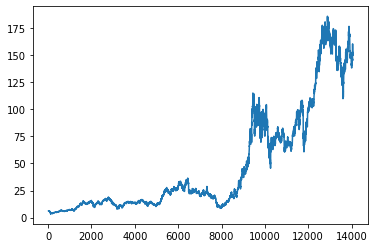

In [34]:
df['Open'].plot()

# GridSearch

In [35]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

pipeline = Pipeline([
    ("drop_columns", col_dropper),
    ("scaling", scaler),
    ("model", model)
])   

params = {
    "model__n_estimators" : [100, 200, 300],
    "model__learning_rate" : np.logspace(-1, -5, 5)    
}

grid = GridSearchCV(pipeline, params, cv = TimeSeriesSplit(3), n_jobs = 4)

grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('drop_columns',
                                        FunctionTransformer(func=<function drop_columns at 0x12551c3a0>)),
                                       ('scaling', StandardScaler()),
                                       ('model',
                                        GradientBoostingClassifier())]),
             n_jobs=4,
             param_grid={'model__learning_rate': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05]),
                         'model__n_estimators': [100, 200, 300]})

# Évaluation du modèle optimisé

In [36]:
pipeline = grid.best_estimator_

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(cr(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.38      0.50      2463
           1       0.48      0.81      0.61      1749

    accuracy                           0.56      4212
   macro avg       0.61      0.60      0.55      4212
weighted avg       0.63      0.56      0.55      4212



# Enregistrement du modèle


In [88]:
from joblib import dump,load

transformers = pipeline.steps

dump(transformers[1][1], 'scaler.joblib')

dump(transformers[2][1], 'model.joblib')

['model.joblib']

FunctionTransformer(func=<function drop_columns at 0x000001A7749728B0>)

In [ ]:
from joblib import dump, load




dump(clf, 'clf.joblib') 

clf = load('clf.joblib')

# Backtesting

In [91]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG


class Ma_strategie(Strategy):

    def init(self):
        self.model = pipeline

    def next(self):
        jour_en_cours = self.data.df.iloc[-1:]
        
        volatilite_estimee = self.model.predict(jour_en_cours)
        
        if volatilite_estimee:
            if jour_en_cours['Open'].iloc[0] > jour_en_cours['Open_1'].iloc[0]:
                self.buy()
            else:
                self.sell()

bt = Backtest(X_test, Ma_strategie,
              cash=10000, commission=0,
              exclusive_orders=True)

output = bt.run()
fig = bt.plot()

<ipython-input-91-99b946bb03c5>:23: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(X_test, Ma_strategie,


In [92]:
from bokeh.plotting import show

st.bokeh_chart(fig)

In [93]:
output

Start                                    9847
End                                     14058
Duration                                 4211
Exposure Time [%]                     99.9525
Equity Final [$]                        11964
Equity Peak [$]                       25014.4
Return [%]                            19.6399
Buy & Hold Return [%]                 52.9925
Return (Ann.) [%]                         NaN
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                      -58.44
Avg. Drawdown [%]                    -6.47867
Max. Drawdown Duration                   2591
Avg. Drawdown Duration                99.3571
# Trades                                 2688
Win Rate [%]                          49.9628
Best Trade [%]                        13.2277
Worst Trade [%]                      -13.6227
Avg. Trade [%]                    